In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["LD_LIBRARY_PATH"]

'/vol/cuda/11.2.1-cudnn8.1.0.77/targets/x86_64-linux/lib:/vol/cuda/11.2.1-cudnn8.1.0.77/lib64:'

In [2]:
import gpflow
import tensorflow as tf
from gpflow.config import default_float
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(0)
np.random.seed(0)

In [3]:
import tensorflow as tf
import numpy as np
from gpflow.models import GPModel, SVGP
from gpflow.base import Parameter
from gpflow.models.training_mixins import ExternalDataTrainingLossMixin
from gpflow.mean_functions import MeanFunction
from gpflow import posteriors
from gpflow.kullback_leiblers import gauss_kl
from gpflow.config import default_jitter, default_float
from gpflow.utilities import positive, triangular
from gpflow.models.util import inducingpoint_wrapper
from gpflow.conditionals.util import sample_mvn
from gpflow.quadrature import NDiagGHQuadrature
# from gparkme.posteriors import create_posterior
from typing import Optional


class GPCDE(SVGP):
    def __init__(
        self,
        kernel,
        likelihood,
        inducing_variable,
        mean_function: Optional[MeanFunction] = None,
        num_quadrature: int = 10,
        q_diag: bool = False,
        whiten: bool = True,
        q_mu=None,
        q_sqrt=None,
        num_latent_gps=1
    ):
        super().__init__(
            kernel,
            likelihood,
            mean_function=mean_function,
            num_latent_gps=num_latent_gps,
            q_diag=q_diag,
            whiten=whiten,
            inducing_variable=inducing_variable,
            q_mu=q_mu,
            q_sqrt=q_sqrt,
        )
        self.num_quadrature = num_quadrature

    def _init_quadrature(self, X, Y, num_minibatch = 100):
        self.num_data= X.shape[0]
        self.num_dim = X.shape[1]
        self.num_minibatch = num_minibatch
        self.quadrature = NDiagGHQuadrature(1, self.num_quadrature)
        quadrature_locs, quadrature_weights = self.quadrature._build_X_W(np.zeros(1), np.ones(1))
        self.quadrature_weights = quadrature_weights[:,0]
        self.quadrature_weights = self.quadrature_weights[None, :]
        quadrature_locs = tf.expand_dims(quadrature_locs, axis=0)
        quadrature_locs = tf.tile(quadrature_locs, multiples=[X.shape[0],1,1])
        X = X[:,None,:]
        Y = Y[:,None,:]
        X = tf.tile(X, multiples=[1, self.num_quadrature, 1])
        Y = tf.tile(Y, multiples=[1, self.num_quadrature, 1])
        X = tf.concat([X, quadrature_locs],axis=-1)
        ds = tf.data.Dataset.from_tensor_slices((X, Y))
        ds_iter = iter(ds.repeat().shuffle(self.num_data).batch(num_minibatch))
        return ds_iter

    def predict_f_samples(
        self,
        Xnew,
        obs_noise=False,
        num_samples: Optional[int] = None,
        full_cov: bool = False,
        full_output_cov: bool = False,
    ) -> tf.Tensor:
        """
        Produce samples from the posterior latent function(s) at the input points.
        :param Xnew: InputData
            Input locations at which to draw samples, shape [..., N, D]
            where N is the number of rows and D is the input dimension of each point.
        :param num_samples:
            Number of samples to draw.
            If `None`, a single sample is drawn and the return shape is [..., N, P],
            for any positive integer the return shape contains an extra batch
            dimension, [..., S, N, P], with S = num_samples and P is the number of outputs.
        :param full_cov:
            If True, draw correlated samples over the inputs. Computes the Cholesky over the
            dense covariance matrix of size [num_data, num_data].
            If False, draw samples that are uncorrelated over the inputs.
        :param full_output_cov:
            If True, draw correlated samples over the outputs.
            If False, draw samples that are uncorrelated over the outputs.
        Currently, the method does not support `full_output_cov=True` and `full_cov=True`.
        """
        if full_cov and full_output_cov:
            raise NotImplementedError(
                "The combination of both `full_cov` and `full_output_cov` is not supported."
            )

        # check below for shape info
        mean, cov = self.predict_f(Xnew, full_cov=full_cov, full_output_cov=full_output_cov)
        if obs_noise is True and full_cov is False:
            cov += self.likelihood.variance
        if full_cov:
            # mean: [..., N, P]
            # cov: [..., P, N, N]
            mean_for_sample = tf.linalg.adjoint(mean)  # [..., P, N]
            samples = sample_mvn(
                mean_for_sample, cov, full_cov, num_samples=num_samples
            )  # [..., (S), P, N]
            samples = tf.linalg.adjoint(samples)  # [..., (S), N, P]
        else:
            # mean: [..., N, P]
            # cov: [..., N, P] or [..., N, P, P]
            samples = sample_mvn(
                mean, cov, full_output_cov, num_samples=num_samples
            )  # [..., (S), N, P]
        return samples  # [..., (S), N, P]

    def predict_full_samples_layer(self, Xnew, obs_noise=False, num_latent_samples=50, num_gp_samples=50):
        w = np.random.normal(size=(num_latent_samples, Xnew.shape[0], 1))
        sampling_func = lambda x: self.predict_f_samples(x, obs_noise=obs_noise, num_samples=num_gp_samples)

        def sample_latent_gp(w_single):
            X = np.concatenate([Xnew, w_single], axis=1)
            samples = sampling_func(X)
            return samples

        samples = tf.map_fn(sample_latent_gp, w)

        return samples

    def predict_credible_layer(
        self,
        Xnew,
        lower_quantile=2.5,
        upper_quantile=97.5,
        num_gp_samples=50,
        num_latent_samples=50,
        obs_noise=False,
    ):

        samples = self.predict_full_samples_layer(
            Xnew,
            obs_noise=obs_noise,
            num_gp_samples=num_gp_samples,
            num_latent_samples=num_latent_samples,
        )
        lower = np.percentile(samples, lower_quantile, axis=[0,1])
        median = np.percentile(samples, 50, axis=[0,1])
        upper = np.percentile(samples, upper_quantile, axis=[0,1])

        return lower, median, upper, samples


    def maximum_log_likelihood_objective(self, data) -> tf.Tensor:
        return self.elbo(data)

    def elbo(self, data) -> tf.Tensor:
        """
        This gives a variational bound (the evidence lower bound or ELBO) on
        the log marginal likelihood of the model.
        """
        X, Y = data
        X = tf.reshape(X, (self.num_minibatch*self.num_quadrature, self.num_dim+1))
        Y = tf.reshape(Y, (self.num_minibatch*self.num_quadrature, 1))
        kl = self.prior_kl()
        f_mean, f_var = self.predict_f(X)
        var_exp = self.likelihood.variational_expectations(f_mean, f_var, Y)
        # each var_exp is (num_minibatch, num_quadrature, 1)
        var_exp = tf.reshape(var_exp, (self.num_minibatch, self.num_quadrature))
        if self.num_data is not None:
            num_data = tf.cast(self.num_data, kl.dtype)
            minibatch_size = tf.cast(tf.shape(X)[0], kl.dtype)
            scale = num_data / minibatch_size
        else:
            scale = tf.cast(1.0, kl.dtype)

        # var_exp = tf.reduce_sum(var_exp, axis=0) * scale
        quadrature_weights = self.quadrature_weights
        term1 = tf.math.reduce_logsumexp(var_exp + tf.math.log(quadrature_weights),axis=1)
        return tf.reduce_sum(term1) * scale - kl


In [12]:
from tqdm import trange
from gpflow.optimizers import NaturalGradient
import gpflow
import matplotlib.pyplot as plt


def run_optimizer(model, ds_iter, iterations):
    """
    Utility function running the Adam optimizer
    Modified from https://gpflow.readthedocs.io/en/master/notebooks/advanced/gps_for_big_data.html
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    training_loss = model.training_loss_closure(ds_iter, compile=True)
    gpflow.set_trainable(model.q_mu, False)
    gpflow.set_trainable(model.q_sqrt, False)
    variational_params = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = NaturalGradient(gamma=0.1)
    optimizer = tf.optimizers.Adam(0.01)
    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)
        natgrad_opt.minimize(training_loss, variational_params)
    iterator = trange(iterations) 
    for step in iterator:
        optimization_step()
        elbo = -training_loss().numpy()
        logf.append(elbo)
        if step % 1000 == 0:
            # elbo = -training_loss().numpy()
            # logf.append(elbo)
            iterator.set_description(f"EPOCH: {step}, ELBO: {elbo}")


            obs_new = np.linspace(-5, 5, 3000)[:, None]

            lower, median, upper, samples = model.predict_credible_layer(
                Xnew=obs_new,
                obs_noise=True
            )
            plt.scatter(X[:, 0], Y[:, 0], c='r')
            plt.plot(obs_new, median, c='b', alpha=0.2)
            # plt.scatter(obs_new[:, 0], samples[0, 0], alpha=0.5)
            plt.fill_between(obs_new[:, 0], upper[:, 0], lower[:, 0], alpha=0.5)
            plt.show()
            plt.close()

            if np.abs(np.mean(logf[-2500:])) - np.abs(np.mean(logf[-100:])) < np.std(logf[-100:]):
                print
                break
            
    return logf

In [13]:
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")
from data.get_data import get_gauss_pairs_dataset

x, y, _, _ = get_gauss_pairs_dataset("/vol/bitbucket/ad6013/Research/gp-causal/data/gauss_pairs/files")
# Get data
# X = np.random.randn(2000, 1)
# Y = (X) + X  * (np.random.randn(2000, 1))
X = x[0]
Y = y[0]
N = X.shape[0]
num_minibatch = 100


X = StandardScaler().fit_transform(X).astype(np.float64)
Y = StandardScaler().fit_transform(Y).astype(np.float64)

In [14]:
M = 200  # Number of inducing locations

kernel_1 = gpflow.kernels.SquaredExponential(
    lengthscales=[0.03, 0.1]
    # lengthscales=[lengthscales[0], lengthscales[1]]
)
# kernel_1.variance.assign(kernl_var)
kernel_2 = gpflow.kernels.Linear()
kernel = gpflow.kernels.Sum([kernel_1, kernel_2])
Z = np.concatenate(
        [
            np.linspace(X.min(), X.max(), M).reshape(-1, 1),
            # X[:M, :].copy(),
            np.random.randn(M, 1),
        ],
        axis=1
    )
model = GPCDE(
    kernel=kernel,
    likelihood=gpflow.likelihoods.Gaussian(
        variance=1e-5
        # variance=m.likelihood.variance.numpy(),
    ),
    inducing_variable=Z,
    num_quadrature=100,
    whiten=True
)
ds_iter = model._init_quadrature(X=X, Y=Y, num_minibatch=num_minibatch)

EPOCH: 0, ELBO: -683867.823656994:   0%|          | 0/50000 [00:01<?, ?it/s]

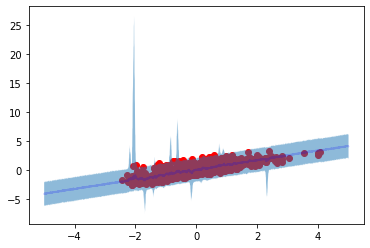

EPOCH: 1000, ELBO: -3968.5028492267948:   2%|▏         | 1000/50000 [00:41<30:45, 26.55it/s]

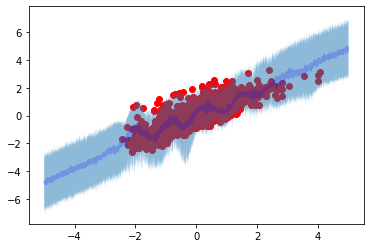

EPOCH: 2000, ELBO: -1989.441418834267:   4%|▍         | 1999/50000 [01:20<30:08, 26.54it/s]   

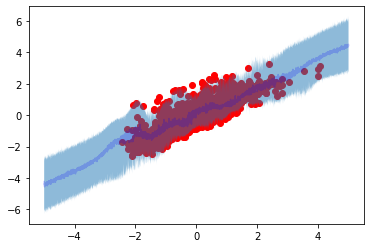

EPOCH: 3000, ELBO: -961.4446699522462:   6%|▌         | 2998/50000 [02:00<29:21, 26.69it/s]  

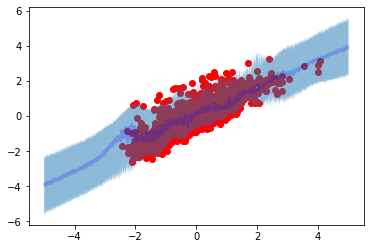

EPOCH: 4000, ELBO: -746.8328381755948:   8%|▊         | 4000/50000 [02:40<28:51, 26.57it/s]  

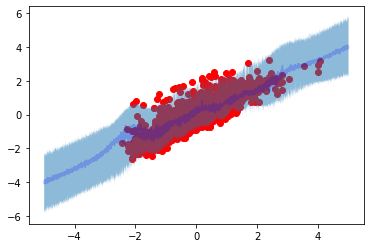

EPOCH: 5000, ELBO: -571.5163005966448:  10%|▉         | 4999/50000 [03:20<28:06, 26.68it/s]  

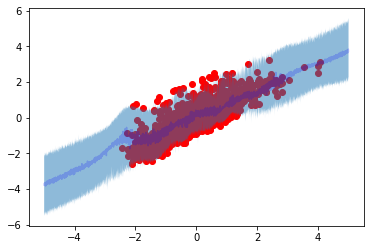

EPOCH: 6000, ELBO: -372.22049867598344:  12%|█▏        | 5998/50000 [03:59<27:26, 26.73it/s] 

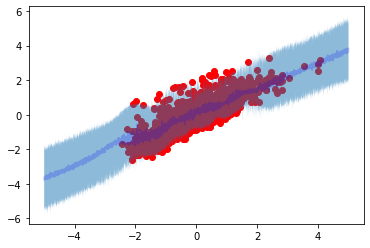

EPOCH: 7000, ELBO: -242.35494394193108:  14%|█▍        | 7000/50000 [04:39<26:51, 26.69it/s]  

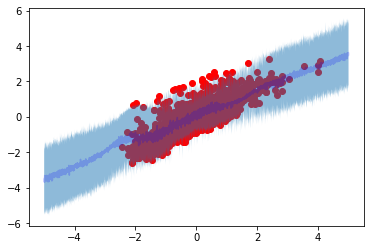

EPOCH: 8000, ELBO: -171.32381857525831:  16%|█▌        | 7999/50000 [05:19<26:15, 26.66it/s]  

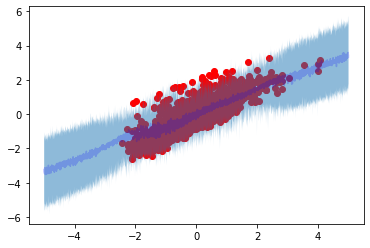

EPOCH: 9000, ELBO: -106.03622084677272:  18%|█▊        | 8998/50000 [05:58<25:29, 26.80it/s]  

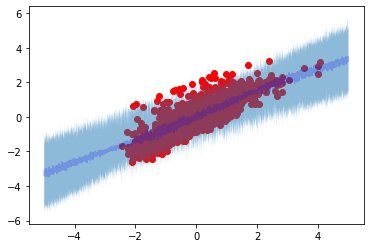

EPOCH: 10000, ELBO: -85.84745076199064:  20%|██        | 10000/50000 [06:38<24:53, 26.79it/s] 

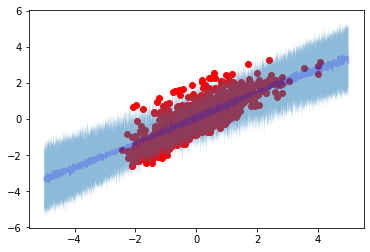

EPOCH: 11000, ELBO: -57.5920428146647:  22%|██▏       | 10999/50000 [07:17<24:13, 26.83it/s]   

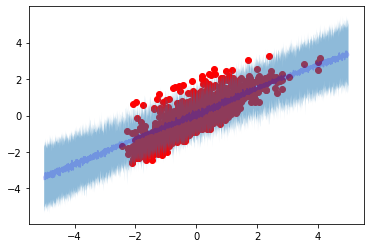

EPOCH: 12000, ELBO: -48.925067232634106:  24%|██▍       | 11998/50000 [07:57<23:38, 26.78it/s]

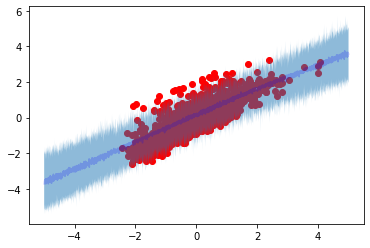

EPOCH: 13000, ELBO: -30.12573093468043:  26%|██▌       | 13000/50000 [08:36<22:53, 26.93it/s]   

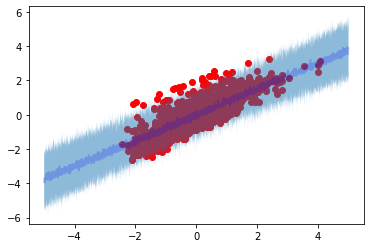

EPOCH: 14000, ELBO: -23.872153815615142:  28%|██▊       | 13999/50000 [09:16<22:16, 26.93it/s] 

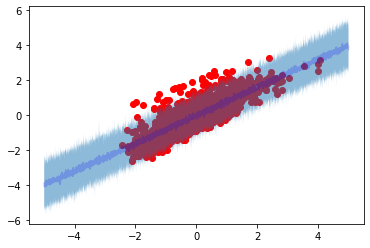

EPOCH: 15000, ELBO: -20.91769881844479:  30%|██▉       | 14998/50000 [09:55<21:36, 27.00it/s]   

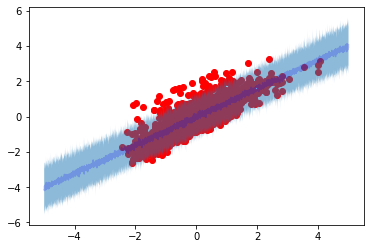

EPOCH: 16000, ELBO: -19.81693274792199:  32%|███▏      | 16000/50000 [10:34<20:50, 27.18it/s]  

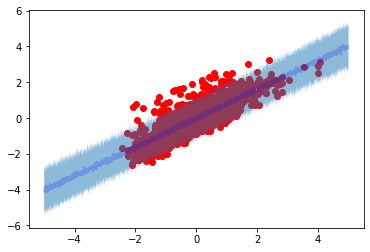

EPOCH: 17000, ELBO: -18.500827640407387:  34%|███▍      | 16999/50000 [11:13<20:03, 27.42it/s] 

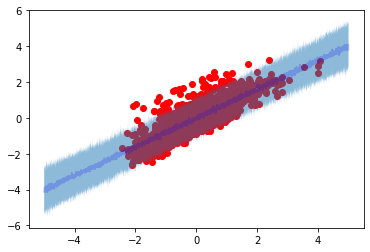

EPOCH: 18000, ELBO: -15.998381129856366:  36%|███▌      | 17998/50000 [11:51<19:02, 28.00it/s]  

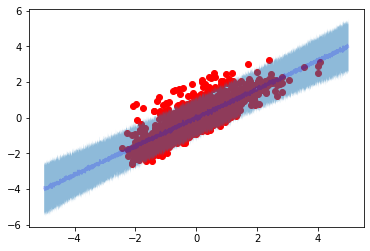

EPOCH: 19000, ELBO: -14.729934686636012:  38%|███▊      | 19000/50000 [12:29<18:28, 27.97it/s]  

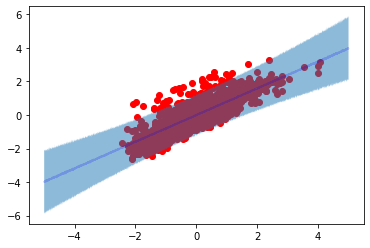

EPOCH: 20000, ELBO: -15.790461450210321:  40%|███▉      | 19999/50000 [13:07<17:52, 27.98it/s]  

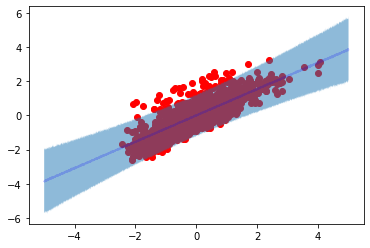

EPOCH: 20000, ELBO: -15.790461450210321:  40%|████      | 20000/50000 [13:10<19:45, 25.32it/s]


In [15]:
logf = run_optimizer(
    model=model,
    ds_iter=ds_iter,
    iterations=50000
)

In [114]:
np.abs(np.mean(logf[-5000:])) - np.abs(np.mean(logf[-100:])) 

1.8083784620472763

In [115]:
np.std(logf[-100:])

2.468514304061991

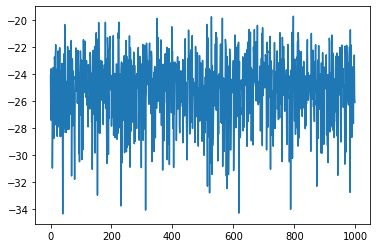

In [116]:
newlogf = logf[-1000:]
plt.plot(np.arange(len(newlogf)), newlogf)
plt.show()

In [118]:
N = X.shape[0]
model.num_minibatch = N
full_ds_iter = model._init_quadrature(X, Y, N)
num_quadrature = 100
def _init_quadrature(X, Y, num_minibatch = 100):
    num_data= X.shape[0]
    num_dim = X.shape[1]
    num_minibatch = num_minibatch
    quadrature = NDiagGHQuadrature(1, num_quadrature)
    quadrature_locs, quadrature_weights = quadrature._build_X_W(np.zeros(1), np.ones(1))
    quadrature_weights = quadrature_weights[:,0]
    quadrature_weights = quadrature_weights[None, :]
    quadrature_locs = tf.expand_dims(quadrature_locs, axis=0)
    quadrature_locs = tf.tile(quadrature_locs, multiples=[X.shape[0],1,1])
    X = X[:,None,:]
    Y = Y[:,None,:]
    X = tf.tile(X, multiples=[1, num_quadrature, 1])
    Y = tf.tile(Y, multiples=[1, num_quadrature, 1])
    X = tf.concat([X, quadrature_locs],axis=-1)
    # ds = tf.data.Dataset.from_tensor_slices((X, Y))
    # ds_iter = iter(ds.shuffle(self.num_data).batch(num_minibatch))
    return X, Y

ds_full = _init_quadrature(X, Y, N)
full_elbo = model.elbo(ds_full)
print(f"Full ELBO: {- full_elbo}")

Full ELBO: 25.22534330304436


EPOCH: 0, ELBO: -918512.3188651084:   0%|          | 0/50000 [00:01<?, ?it/s]

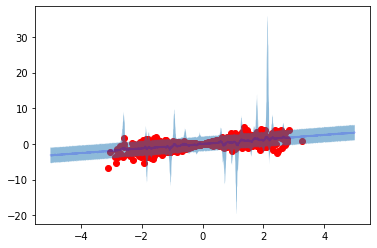

EPOCH: 1000, ELBO: -10942.64207084037:   2%|▏         | 1000/50000 [00:41<30:51, 26.46it/s]

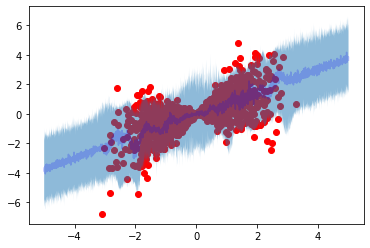

EPOCH: 2000, ELBO: -4388.5386814588555:   4%|▍         | 1999/50000 [01:20<30:04, 26.60it/s] 

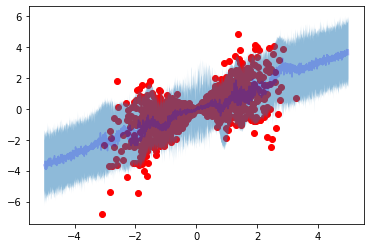

EPOCH: 3000, ELBO: -2924.5708547562704:   6%|▌         | 2998/50000 [02:00<29:19, 26.72it/s]  

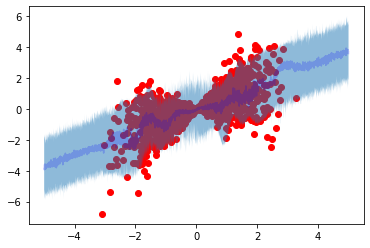

EPOCH: 4000, ELBO: -2022.08388753105:   8%|▊         | 4000/50000 [02:40<28:49, 26.59it/s]    

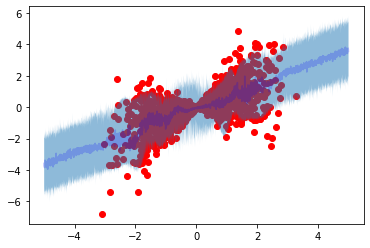

EPOCH: 5000, ELBO: -1503.798646410291:  10%|▉         | 4999/50000 [03:20<28:14, 26.56it/s] 

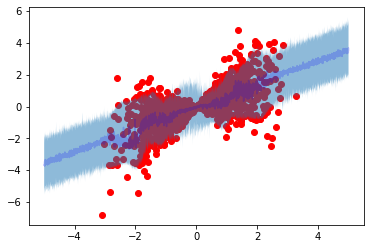

EPOCH: 6000, ELBO: -719.4942690685832:  12%|█▏        | 5998/50000 [04:00<27:37, 26.55it/s]  

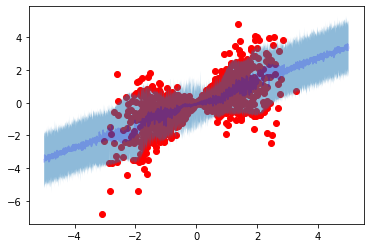

EPOCH: 7000, ELBO: -552.0232215790977:  14%|█▍        | 7000/50000 [04:40<26:58, 26.56it/s]  

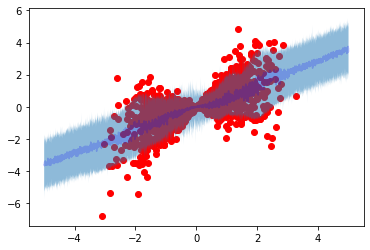

EPOCH: 8000, ELBO: -431.9738616088665:  16%|█▌        | 7999/50000 [05:19<26:17, 26.63it/s]  

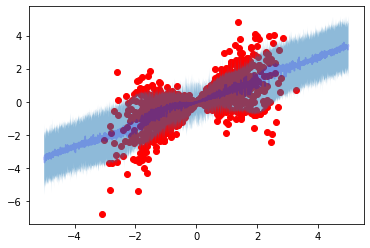

EPOCH: 9000, ELBO: -333.84832011728656:  18%|█▊        | 8998/50000 [05:59<25:39, 26.63it/s] 

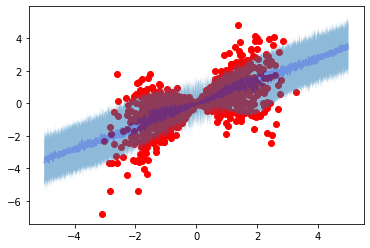

EPOCH: 10000, ELBO: -210.53400160908782:  20%|██        | 10000/50000 [06:39<25:01, 26.63it/s]

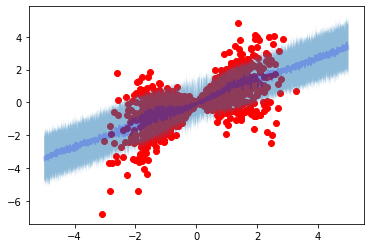

EPOCH: 11000, ELBO: -124.48862657925415:  22%|██▏       | 10999/50000 [07:19<24:21, 26.69it/s]  

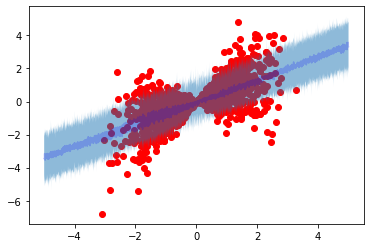

EPOCH: 12000, ELBO: -68.79620116451365:  24%|██▍       | 11998/50000 [07:58<23:45, 26.66it/s]   

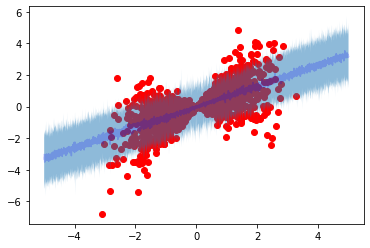

EPOCH: 13000, ELBO: -57.67920763920675:  26%|██▌       | 13000/50000 [08:38<23:05, 26.70it/s]  

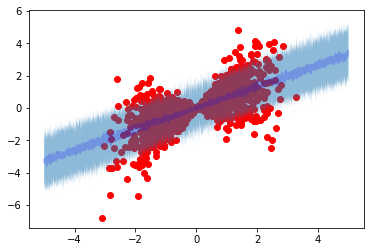

EPOCH: 14000, ELBO: -41.997138544404145:  28%|██▊       | 13999/50000 [09:17<22:20, 26.86it/s] 

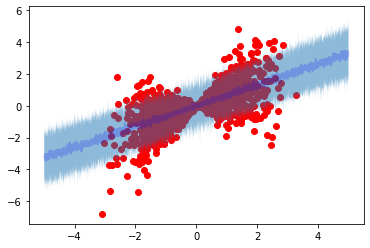

EPOCH: 15000, ELBO: -38.66918318817667:  30%|██▉       | 14998/50000 [09:57<21:45, 26.81it/s]   

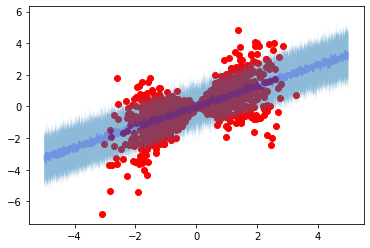

EPOCH: 16000, ELBO: -32.13357461232451:  32%|███▏      | 16000/50000 [10:36<21:05, 26.87it/s]  

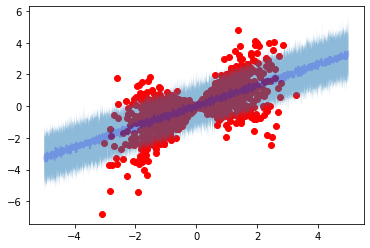

EPOCH: 17000, ELBO: -32.63747934758911:  34%|███▍      | 16999/50000 [11:16<20:24, 26.96it/s]  

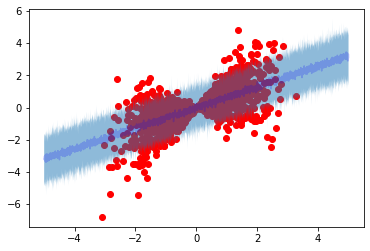

EPOCH: 18000, ELBO: -27.02766852382698:  36%|███▌      | 17998/50000 [11:55<19:44, 27.02it/s]  

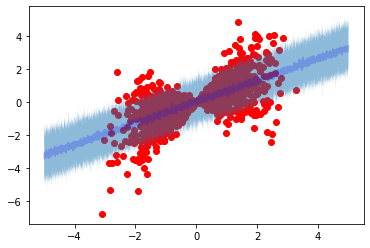

EPOCH: 19000, ELBO: -24.622015711000234:  38%|███▊      | 19000/50000 [12:34<19:04, 27.09it/s] 

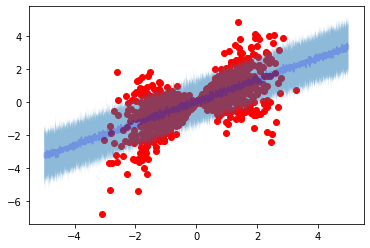

EPOCH: 20000, ELBO: -26.35204010298283:  40%|███▉      | 19999/50000 [13:13<18:16, 27.37it/s]   

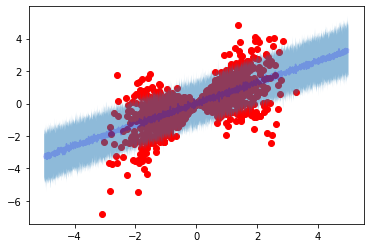

EPOCH: 21000, ELBO: -25.980843588053812:  42%|████▏     | 20998/50000 [13:52<17:22, 27.83it/s] 

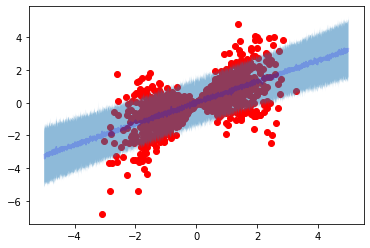

EPOCH: 22000, ELBO: -26.591186067074947:  44%|████▍     | 22000/50000 [14:30<16:46, 27.82it/s]  

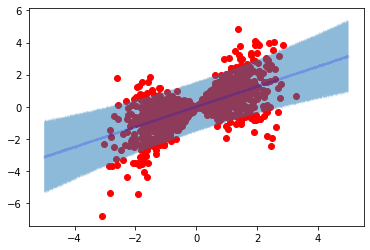

EPOCH: 23000, ELBO: -25.00313803898323:  46%|████▌     | 22999/50000 [15:08<16:04, 28.00it/s]   

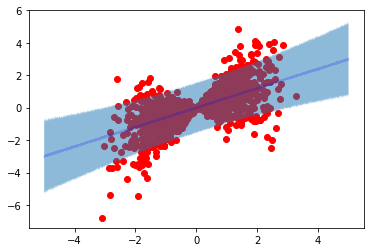

EPOCH: 23000, ELBO: -25.00313803898323:  46%|████▌     | 23000/50000 [15:10<17:49, 25.26it/s]


In [120]:
_ = run_optimizer(
    model=model,
    ds_iter=ds_iter,
    iterations=50000
)

In [122]:
N = X.shape[0]
model.num_minibatch = N
full_ds_iter = model._init_quadrature(X, Y, N)
num_quadrature = 100
def _init_quadrature(X, Y, num_minibatch = 100):
    num_data= X.shape[0]
    num_dim = X.shape[1]
    num_minibatch = num_minibatch
    quadrature = NDiagGHQuadrature(1, num_quadrature)
    quadrature_locs, quadrature_weights = quadrature._build_X_W(np.zeros(1), np.ones(1))
    quadrature_weights = quadrature_weights[:,0]
    quadrature_weights = quadrature_weights[None, :]
    quadrature_locs = tf.expand_dims(quadrature_locs, axis=0)
    quadrature_locs = tf.tile(quadrature_locs, multiples=[X.shape[0],1,1])
    X = X[:,None,:]
    Y = Y[:,None,:]
    X = tf.tile(X, multiples=[1, num_quadrature, 1])
    Y = tf.tile(Y, multiples=[1, num_quadrature, 1])
    X = tf.concat([X, quadrature_locs],axis=-1)
    # ds = tf.data.Dataset.from_tensor_slices((X, Y))
    # ds_iter = iter(ds.shuffle(self.num_data).batch(num_minibatch))
    return X, Y

ds_full = _init_quadrature(X, Y, N)
full_elbo = model.elbo(ds_full)
print(f"Full ELBO: {- full_elbo}")

Full ELBO: 25.168139728948326


In [123]:
model.kernel

name,class,transform,prior,trainable,shape,dtype,value
Sum.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.002342700794680889
Sum.kernels[0].lengthscales,Parameter,Softplus,,True,"(2,)",float64,[1.62291119 1.49776629]
Sum.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.21150986484005352


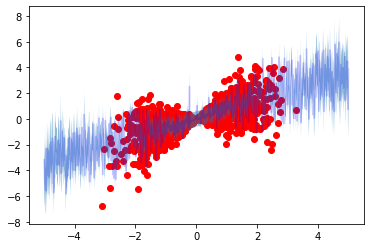

In [15]:
obs_new = np.linspace(-5, 5, 1000)[:, None]

Xnew = tfp.distributions.Normal(loc=0, scale=1).sample([obs_new.shape[0], 1])
Xnew = tf.cast(Xnew, dtype=default_float())
Xnew = tf.concat(
    [obs_new, Xnew], axis=1
)
pred_f_mean, pred_f_var = model.predict_y(
    Xnew=Xnew,
)
plt.scatter(X[:, 0], Y[:, 0], c='r')
plt.plot(obs_new, pred_f_mean, c='b', alpha=0.2)
# plt.scatter(inducing_in, np.zeros(100) )
plt.fill_between(obs_new[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
plt.show()
plt.close()


In [1]:
obs_new = np.linspace(-5, 5, 1000)[:, None]

Xnew = tfp.distributions.Normal(loc=0, scale=1).sample([obs_new.shape[0], 1])
Xnew = tf.cast(Xnew, dtype=default_float())
Xnew = tf.concat(
    [obs_new, Xnew], axis=1
)
pred_f_mean, pred_f_var = model.predict_y(
    Xnew=Xnew,
)
plt.scatter(X[:, 0], Y[:, 0], c='r')
plt.plot(obs_new, pred_f_mean, c='b', alpha=0.2)
# plt.scatter(inducing_in, np.zeros(100) )
plt.fill_between(obs_new[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
plt.show()
plt.close()


NameError: name 'np' is not defined

In [13]:
M = 200  # Number of inducing locations

kernel_1 = gpflow.kernels.SquaredExponential(
    lengthscales=[0.003]
    # lengthscales=[lengthscales[0], lengthscales[1]]
)
# kernel_1.variance.assign(kernl_var)
kernel_2 = gpflow.kernels.Linear()
kernel = gpflow.kernels.Sum([kernel_1, kernel_2])
Z = np.linspace(X.min(), X.max(), M).reshape(-1, 1)
model =  gpflow.models.SVGP(
    kernel, gpflow.likelihoods.Gaussian(variance=1e-5), Z, num_data=N)


In [14]:
minibatch_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)).repeat().shuffle(N)


In [15]:
def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    gpflow.set_trainable(model.q_mu, False)
    gpflow.set_trainable(model.q_sqrt, False)
    variational_params = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = NaturalGradient(gamma=0.1)
    optimizer = tf.optimizers.Adam(0.005)
    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)
        natgrad_opt.minimize(training_loss, variational_params)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

In [16]:
_ = run_adam(
    model, 
    iterations=30000
)

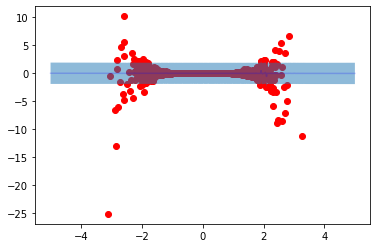

In [17]:
obs_new = np.linspace(-5, 5, 1000)[:, None]

Xnew = obs_new
pred_f_mean, pred_f_var = model.predict_y(
    Xnew=Xnew,
)
plt.scatter(X[:, 0], Y[:, 0], c='r')
plt.plot(obs_new, pred_f_mean, c='b', alpha=0.2)
# plt.scatter(inducing_in, np.zeros(100) )
plt.fill_between(obs_new[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
plt.show()
plt.close()